# Exploring All Geounit Revenue from Submitted Tickets

This notebook analyzes All Geounits revenue from the tickets submited in the system month by month using the global tickets WLES operations data.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

%matplotlib inline

# Set Seaborn style
sns.set_style("whitegrid")  # You can choose any Seaborn style such as "darkgrid", "white", "dark", "ticks"


## Data Loading and Initial Exploration

Let's load the data and take a look at its structure and content.

In [9]:
# Load the data
df = pd.read_csv('../raw_data/global_tickets_wles_ops_data.csv')

# Display the first few rows and data info
print(df.head())
print("\nDataset Info:")
df.info()

  Sl Geounit (Code) Country Name Job Group code Job Type code  \
0               BRZ       Brazil           WLES     ES-OH-Ops   
1               BRZ       Brazil           WLES     ES-CH-Ops   
2               ABC        Chile           WLES     ES-OH-Ops   
3               ABC    Argentina           WLES     ES-CH-Ops   
4               BRZ       Brazil           WLES     ES-OH-Ops   

       Activity ID          Booking Status         Field Ticket ID  \
0  A.1002789.17.01  Operationally Complete  1002789.O0Z32.D1D69F8C   
1  A.1002789.17.01  Operationally Complete  1002789.O0Z33.F8B6CC9F   
2  A.1003553.65.01  Operationally Complete  1003553.V2C43.3A74A599   
3  A.1005110.35.01  Operationally Complete  1005110.X6F48.C0D4BAD4   
4  A.1035019.03.02  Operationally Complete   1035019.U0G4.C14D5511   

  Field Ticket Start Date Field Ticket End Date      Well Name Rig Name  \
0     2022-09-04 03:00:00   2022-09-26 02:59:00  8-BUZ-59D-RJS      NaN   
1     2022-09-04 03:00:00   2022-09-26

# Exploring Job Type Codes

In this section, we'll analyze the 'Job Type code' column to better understand the distribution of different job types in our dataset. This analysis will help us:

1. Identify the unique job types present in the data
2. Determine the frequency of each job type
3. Calculate the percentage distribution of job types
4. Visualize the distribution using bar plots and pie charts

This exploration will provide insights into the variety of jobs represented in our dataset and their relative prevalence, which could be crucial for understanding the nature of the work being performed and potentially identifying any imbalances or patterns in job type distribution.

Number of unique Job Type codes: 2

Unique Job Type codes:
['ES-OH-Ops' 'ES-CH-Ops']

Job Type code counts:
Job Type code
ES-OH-Ops    11404
ES-CH-Ops     6509
Name: count, dtype: int64

Job Type code percentages:
Job Type code
ES-OH-Ops    63.66
ES-CH-Ops    36.34
Name: count, dtype: float64


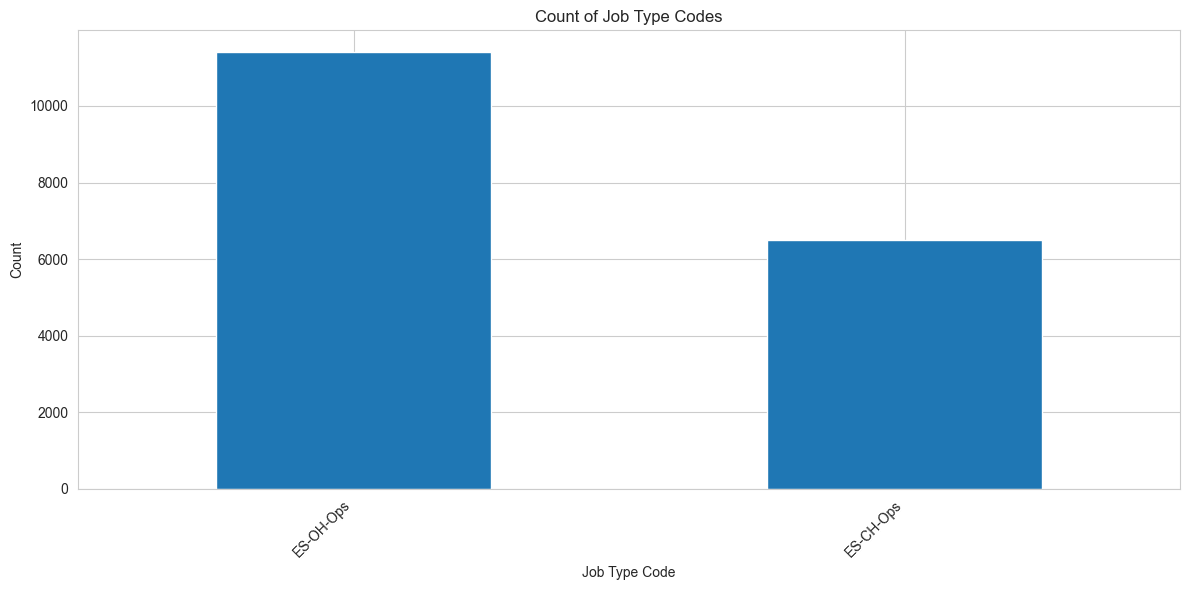

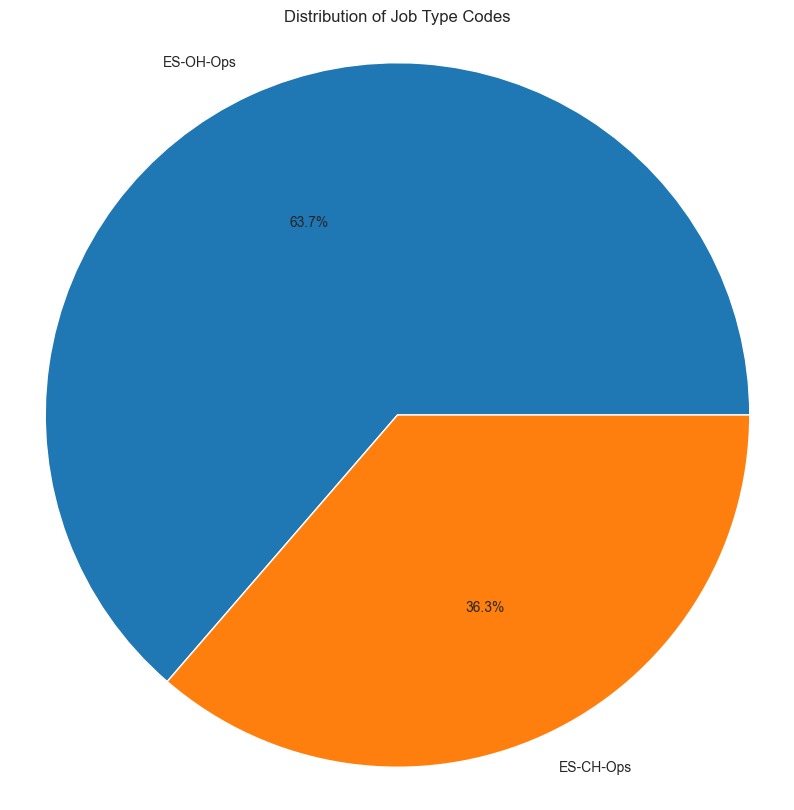

In [10]:
# Explore unique values in Job Type code column

# Get unique Job Type codes
job_types = df['Job Type code'].unique()

# Count occurrences of each Job Type code
job_type_counts = df['Job Type code'].value_counts()

print(f"Number of unique Job Type codes: {len(job_types)}")
print("\nUnique Job Type codes:")
print(job_types)

print("\nJob Type code counts:")
print(job_type_counts)

# Calculate percentage of each Job Type code
job_type_percentages = (job_type_counts / len(df) * 100).round(2)

print("\nJob Type code percentages:")
print(job_type_percentages)

# Create a bar plot of Job Type code counts
plt.figure(figsize=(12, 6))
job_type_counts.plot(kind='bar')
plt.title('Count of Job Type Codes')
plt.xlabel('Job Type Code')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a pie chart of Job Type code percentages
plt.figure(figsize=(10, 10))
plt.pie(job_type_percentages, labels=job_type_percentages.index, autopct='%1.1f%%')
plt.title('Distribution of Job Type Codes')
plt.axis('equal')
plt.show()

## Data Preprocessing

Now, let's preprocess the data to prepare it for our analysis:
1. Convert date columns to datetime format
2. Extract month and year from the end date, applying the following rule:
   - If the date is from the 1st to the 25th (inclusive), use that month
   - If the date is from the 26th onwards, use the subsequent month
3. Group the data by Geounit and Month-Year, summing the revenue

In [12]:
# Data Preprocessing

# Import the preprocessing function
import importlib
import utils.revenue_data_preprocessing as rdp
importlib.reload(rdp)
print(dir(rdp))

# Apply the preprocessing function
df = rdp.preprocess_tickets_data(df)

# 3. Group the data by Geounit and Month-Year, summing the revenue
grouped_data = df.groupby(['Sl Geounit (Code)', pd.Grouper(key='Adjusted Date', freq='MS')])['Field Ticket USD net value'].sum().reset_index()

# Rename columns for clarity
grouped_data.columns = ['Geounit', 'Date', 'Revenue']

# Sort the data by Geounit and Date
grouped_data = grouped_data.sort_values(['Geounit', 'Date'])

# Display the first few rows of the processed data
print(grouped_data.head(10))

# Display summary statistics
print("\nSummary Statistics:")
print(grouped_data.describe())

# Check for any missing values
print("\nMissing Values:")
print(grouped_data.isnull().sum())

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'adjust_month', 'pd', 'preprocess_rpe_data', 'preprocess_tickets_data']
  Geounit       Date     Revenue
0     ABC 2022-10-01  1709675.28
1     ABC 2022-11-01  1997028.25
2     ABC 2022-12-01  3073292.37
3     ABC 2023-01-01  2313247.37
4     ABC 2023-02-01  2786216.10
5     ABC 2023-03-01  3736382.98
6     ABC 2023-04-01  3855089.36
7     ABC 2023-05-01  3908612.73
8     ABC 2023-06-01  3025783.99
9     ABC 2023-07-01  4266043.16

Summary Statistics:
                                Date       Revenue
count                            641  6.410000e+02
mean   2023-08-25 23:35:17.316692736  3.339193e+06
min              2022-10-01 00:00:00  0.000000e+00
25%              2023-03-01 00:00:00  1.175090e+06
50%              2023-09-01 00:00:00  2.347485e+06
75%              2024-02-01 00:00:00  4.266043e+06
max              2024-08-01 00:00:00  2.387705e+07
std                          

## Visualization: Monthly Revenue by Geounit

Let's create a line plot to visualize the monthly revenue trends for each Geounit.

In [13]:
import ipywidgets as widgets
from ipywidgets import interact

# Function to plot revenue over time for selected geounits
def plot_revenue_over_time(selected_geounits):
    plt.figure(figsize=(15, 8))
    
    for geounit in selected_geounits:
        data = grouped_data[grouped_data['Geounit'] == geounit]
        plt.plot(data['Date'], data['Revenue'], label=geounit)
    
    plt.title('Revenue Over Time by Geounit', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Revenue (USD)', fontsize=12)
    plt.legend(title='Geounit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Get unique geounits
geounits = sorted(grouped_data['Geounit'].unique())

# Create multi-select widget
geounit_selector = widgets.SelectMultiple(
    options=geounits,
    value=[geounits[0]],  # Default to first geounit
    description='Geounits:',
    disabled=False
)

# Create interactive plot
interact(plot_revenue_over_time, selected_geounits=geounit_selector)

# Display summary statistics for all geounits
print("Summary Statistics by Geounit:")
summary_stats = grouped_data.groupby('Geounit')['Revenue'].agg(['mean', 'median', 'min', 'max']).round(2)
summary_stats.columns = ['Mean Revenue', 'Median Revenue', 'Min Revenue', 'Max Revenue']
display(summary_stats)

interactive(children=(SelectMultiple(description='Geounits:', index=(0,), options=('ABC', 'ACE', 'APG', 'ASG',…

Summary Statistics by Geounit:


,Mean Revenue,Median Revenue,Min Revenue,Max Revenue
Geounit,,,,
ABC,2683910.01,2595168.98,301175.88,5333728.18
ACE,2126331.69,1760766.11,166319.69,5728034.44
APG,1692935.81,1529585.22,0.00,3654704.42
ASG,324794.12,354309.12,203832.13,386726.11
AZT,366780.15,370525.92,58312.32,920381.58
BRZ,1918312.51,1540795.87,96297.47,5456550.19
CAL,517675.52,374007.34,46886.45,1328414.35
CHG,7357818.61,7398106.95,505009.18,12388930.38
EAG,1550176.69,1264492.91,7125.00,3579769.04


## Analysis

From the plot above, we can observe the following:

1. Different Geounits have varying levels of revenue.
2. Some Geounits show more volatility in their monthly revenue than others.
3. There might be seasonal patterns or trends for certain Geounits.

To further analyze this data, we could:
- Calculate and compare the average monthly revenue for each Geounit
- Identify the top-performing Geounits
- Analyze the revenue trends over time for specific Geounits of interest
- Investigate any correlation between revenue and other variables in the dataset